Install libraries

In [ ]:
!pip install -r requirements.txt

# Simulator

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *
from dispatch.dispatch import Dispatch
from simulator.simulator import Simulator
from simulator.graphics import plot_CR, plot_counts

# import importlib
# importlib.reload(utils)

Let's firstly 2 main objects of the project:
* dispatch - the box, that assigns couriers on orders
* simulator - a virtual environment that simulates the real world

You can configure the simulator parameters in `environment_config.json` file

In [7]:
dsp = Dispatch() 
sim = Simulator(step=0.5) # the step is the distance which courier makes for each iteration of dispatch

The code below visualizes per-iteration snapshots of all active routes

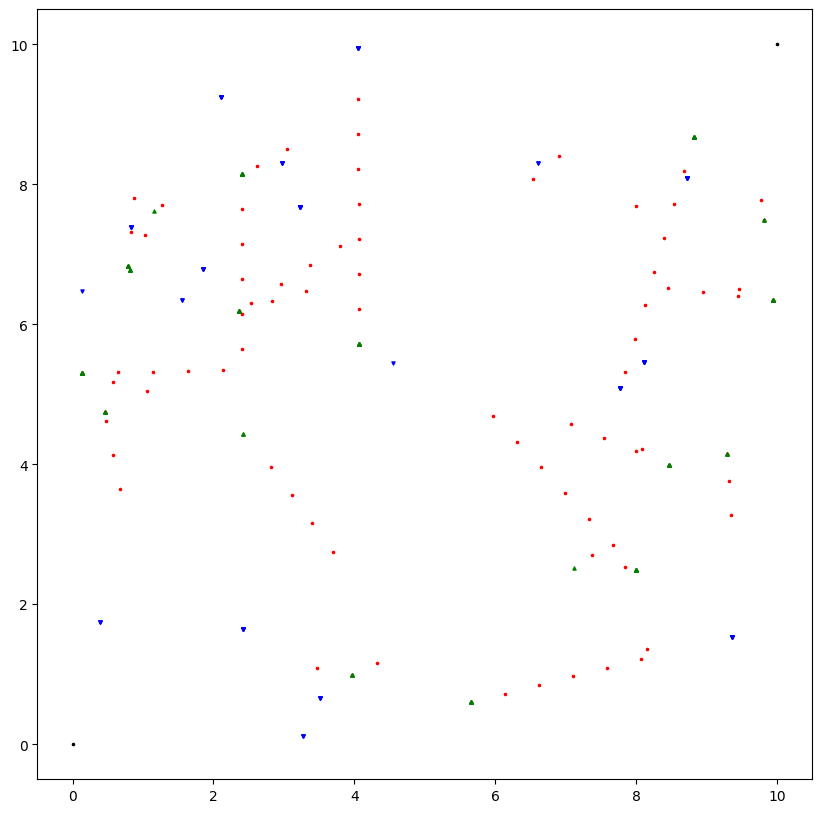

In [8]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
sim.corner_bounds[0].plot(ax, color='black')
sim.corner_bounds[1].plot(ax, color='black')

all_metrics = []
for i in range(10): # run simulator for 10 iterations
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    state = sim.GetState()
    sim.Next(dsp(state))
    for ar in sim.active_routes.items():
        ar.plot(ax)

Also, we can see by-iterations statistics of the whole simulation

In [9]:
pd.DataFrame(all_metrics).set_index('iter')

,completed_orders,finished_orders,current_free_couriers,current_free_orders,current_active_routes,total_eta
iter,,,,,,
0,0,0,20,0,0,0.000000
1,0,0,20,2,0,0.000000
2,0,0,18,2,2,1.530366
3,0,0,16,2,4,1.602200
4,0,0,14,2,6,3.671525
5,0,0,12,2,8,1.381881
6,0,0,10,2,10,2.426896
7,0,0,8,2,12,7.067565
8,0,0,6,2,14,2.270648


Let's run the simulation for longer time and see the convergence of bussiness metrics

In [10]:
all_metrics = []
for i in range(2000): # run simulator for 10 iterations
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    state = sim.GetState()
    sim.Next(dsp(state))

micro average CR:  0.6997518998495371
macro average CR:  0.695489532457396


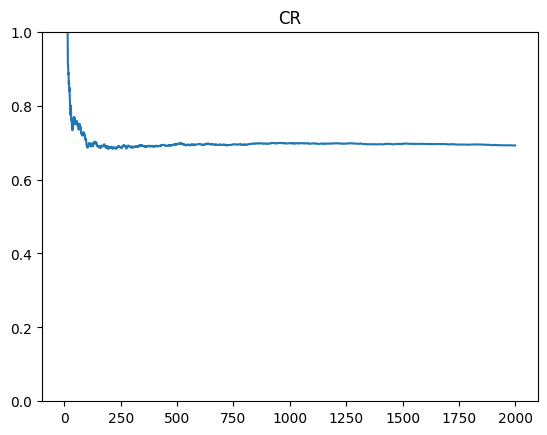

average free couriers:  1.3815
average free orders:  13.215
average active routes:  18.6185


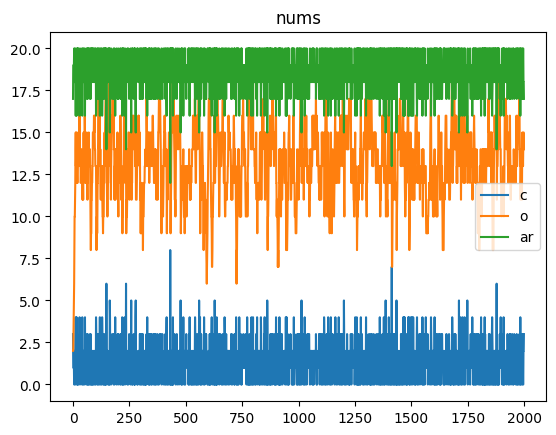

In [11]:
plot_CR(all_metrics)
plot_counts(all_metrics)

Also, we can view some dispatch statistics - more technical metrics

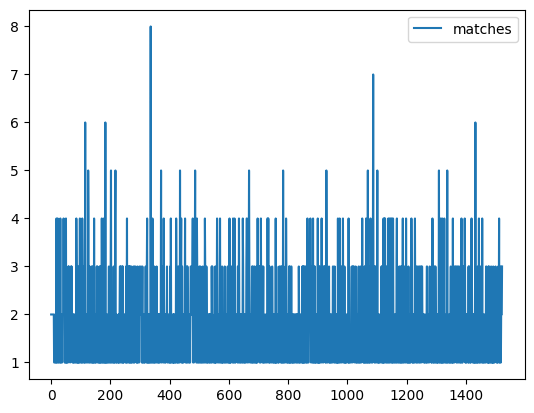

In [13]:
# plt.plot(sim.dispatch.statistics['avg_scores'], label='avg_scores')
plt.plot(dsp.statistics['num_assignments'], label='matches')
plt.legend()
plt.show()

# Neural-network-based dispatch

The idea is to use NNs in dispatch to solve the assignment problem.

Let's firstly decompose the problem

## Positional encoder

Every point is individual. In some areas there can be many orders (because for example there is a storage of big compaby). In some areas there may be bad roads, some the couriers are rare there. That means that we need to encode each point into emdeddings. The PositionalEncoder will do it.

It is trained on the problem of prediction a distance between 2 random points. Embeddings of these points are concated and then followed by linear layer. 

The training code is below

log-losses:  [31.801849212646484, 31.4597487449646, 31.821333541870118, 30.365452404022218, 30.27077646255493]


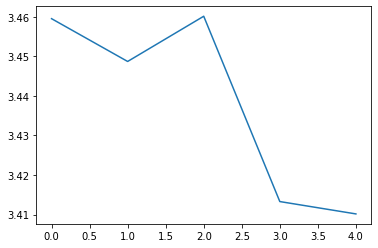

In [19]:
from objects.point import Point, get_random_point
from networks.points_distance_net import PointDistNet
from objects.utils import distance
from IPython.display import clear_output

batch_size = 64
n_epochs = 5
n_iters = 100
bounds = (Point(0, 0), Point(10, 10))
device = None #torch.device('cuda:0')

net = PointDistNet(64, 128, device)
scorer = ETAScoring()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, epochs=n_epochs, steps_per_epoch=n_iters)

losses = []
for epoch in range(n_epochs):
    rolling_loss = []
    for iter in range(n_iters):
        real_distances = []
        pts1 = []
        pts2 = []
        for _ in range(batch_size):
            p1 = get_random_point(bounds)
            p2 = get_random_point(bounds)
            pts1.append(p1)
            pts2.append(p2)
            real_distances.append(distance(p1, p2))

        optimizer.zero_grad()
        mse_loss = nn.MSELoss()
        preds = net(pts1, pts2)
        loss = mse_loss(preds, torch.tensor(real_distances, device=net.device))
        loss.backward()
        optimizer.step()

        rolling_loss.append(loss.item())

    losses.append(np.mean(rolling_loss))
    if epoch % 1 == 0:
        clear_output()
        print('log-losses: ', losses[-50:])
        plt.plot(np.log(losses))
        plt.show()

I trained the model till 0.01-loss convergence. I think that more precision is useless because of overfitting on the exact problem.

In [4]:
import torch
from networks.encoders import PointEncoder
from objects.point import Point, get_random_point
device = torch.device('cpu')
pe = PointEncoder(64, device=device)
pe.load_state_dict(torch.load('pretrained_models/point_encoder64/point_encoder64.pt', map_location=device))

random_point = get_random_point()
embedding = pe(random_point)
print('embedding shape:', embedding.shape)
print('point embedding:', embedding)

embedding shape: torch.Size([64])
point embedding: tensor([ 0.9591, -0.9928, -0.8638,  0.3912,  0.8134, -0.9457, -0.9223,  0.2196,
         0.4088, -0.3766, -0.0237, -0.9824,  0.7664,  0.9947,  0.9416, -0.9989,
        -0.6251, -0.5408, -0.9117,  0.9258, -0.9140, -0.6250, -0.2495, -0.6596,
         0.1941, -0.4378, -0.5329, -0.9989, -0.1660,  0.3313,  0.9114, -0.9399,
        -0.9649, -0.9774, -0.5289, -0.1337, -0.9969, -0.6308,  0.4810, -0.0154,
         0.3818,  0.6911,  0.3756,  0.4150, -0.5642,  0.6101, -0.7954,  0.6954,
        -0.9984, -0.1336, -0.8200, -0.9999,  0.3275,  0.9254, -0.9906, -0.5371,
         0.0275,  0.2973,  0.8066, -0.5628,  0.2780,  0.0167, -0.6116,  0.7915])


## Network architecture

The input of dispatch at every iteration is a GambleTriple.
It contains 3 items:
* list of unassigned orders
* list of unassigned couriers
* list of active routes
Every item in the list can be embedded. For example, a given order has a source point, a destination point and some time information about the order. All these features can be edmedded, so the order can be represented as a vector. The same logic works for courier and active roure. So, the input of our NN is 3 sequnces of vectors. 

The output of the dispatch should be assignments. They can be achieved by solving the maximal matching in bipartite graph. Edges and couriers are the vertexes of this graph. The score of a given edge shows how the corresponding courier suites the corresponding order.
Edges scores can be represented by a matrix of shape [num_orders, num_couriers+1]. '+1' means a fake courier - a given order is not assigned. This matrix is the outpus of our NN.

As a seq2seq problem I solve the problem using Transformer architecture. Every layer of the whole transformer consists of 2 decoders - for the orders and for the couriers. They attend on each other and on active routes. At the end we have in fact a query-key matrix, which is in fact our output

I train the NN on supervised task. 
We have a groundtruth baseine: let's say that the groundtruth baseline of edge score in ETA (distance from corier to a source point). We want to minimize it via Hungarian algoriths which solves exactly our problem. Let's use it's assignments as targets.
To get our NN's predictions we just call softmax of our output matrix.

The code below shows the training process

EPOCH:  1
[3.179408550262451, 2.5416128873825072]


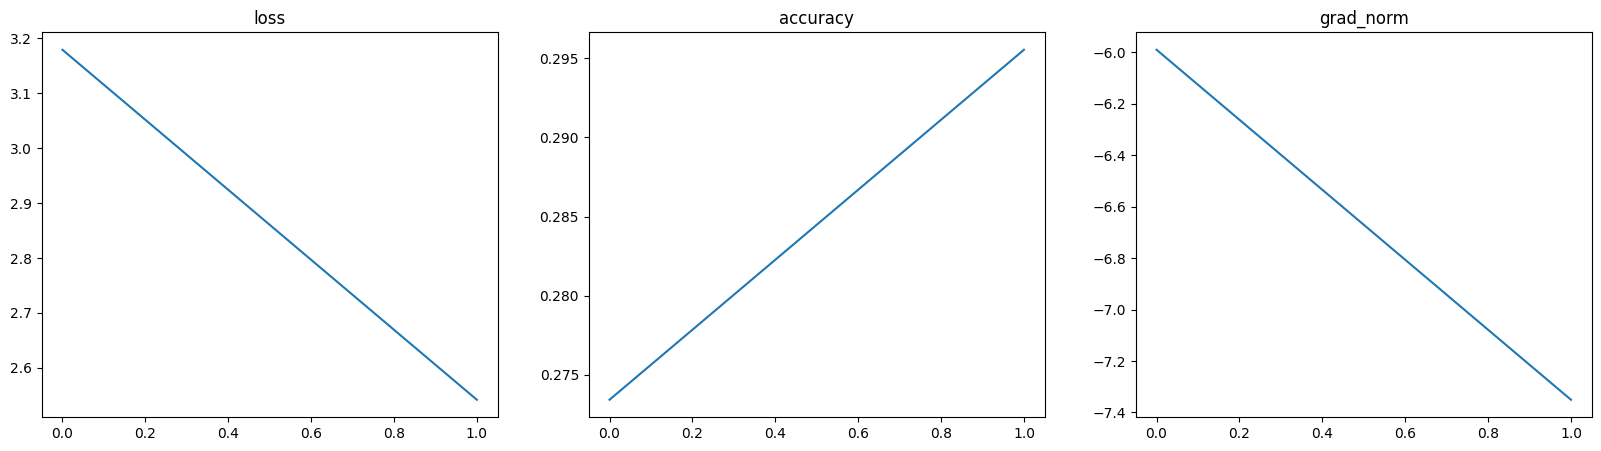

In [1]:
import torch
from objects.point import Point
from networks.scoring_v1 import ScoringNet, ScoringInterface
from networks.encoders import PointEncoder
from objects.gamble_triple import random_triple
from utils import get_loss_solve, print_info, add_avg_grad_norm_metric
import numpy as np

batch_size = 64
n_epochs = 2
n_iters = 10
bounds = (Point(0, 0), Point(10, 10))
light_settings_flg = True
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

point_encoder = PointEncoder(64, device=device)
point_encoder_path = 'pretrained_models/point_encoder64/point_encoder64.pt'
point_encoder.load_state_dict(torch.load(point_encoder_path, map_location=device))

net = ScoringNet(
    mode='default',
    # point_encoder=point_encoder,
    n_layers=2,
    d_model=128,
    n_head=4,
    dim_ff=128,
    point_enc_dim=64,
    number_enc_dim=8,
    device=device
)
model = ScoringInterface(net, point_encoder=point_encoder)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs=n_epochs, steps_per_epoch=n_iters)
scheduler = None

losses = []
metrics = {
    'target_eta': [],
    'net_eta': [],
    'accuracy': [],
    'grad_norm': [],
}

for epoch in range(n_epochs):
    rolling_loss = []
    rolling_metrics = {k: [] for k in metrics.keys()}
    for iter in range(n_iters):
        if light_settings_flg:
            triples = [random_triple(bounds, max_items=5, same_number=True) for _ in range(batch_size)]
        else:
            triples = [random_triple(bounds) for _ in range(batch_size)]

        optimizer.zero_grad()
        loss = get_loss_solve(model, triples, rolling_metrics)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        rolling_loss.append(loss.item())
        add_avg_grad_norm_metric(rolling_metrics, model.net)

    losses.append(np.mean(rolling_loss))
    for k in metrics.keys():
        metrics[k].append(np.mean(rolling_metrics[k]))

    if epoch % 1 == 0:
        print_info(epoch, metrics, losses)

For some purpuses we can visualize a GambleTriple

Orders:
Order; id: 939650352; from: (8.552436545259388, 1.8856253596170303); to: (6.416087455502461, 4.446504934682837)
Couriers:
Courier;  id: 884407024; pos: (3.1143152283254647, 1.342365499350604)
Courier;  id: 195571395; pos: (4.922921114316264, 5.306219642729095)
Courier;  id: 260032619; pos: (1.5561806494247743, 7.0143582726455715)


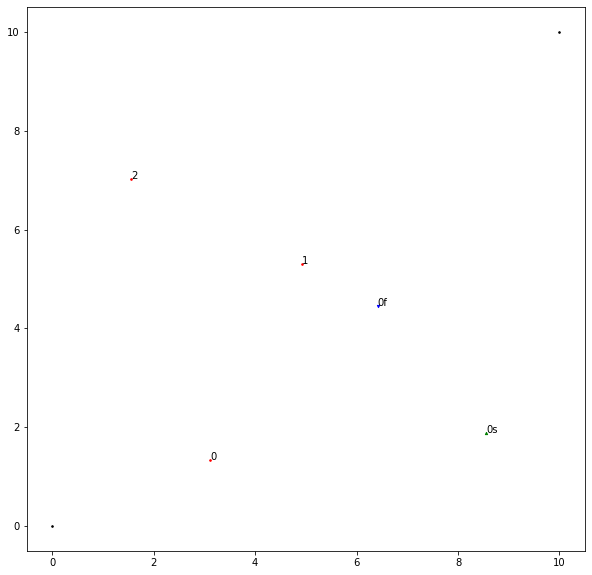

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
    
bounds[0].plot(ax, color='black')
bounds[1].plot(ax, color='black')

random_triple = random_triple(bounds, max_items=3)
print(random_triple)
random_triple.plot(ax)

##  Supervised learning results

No we can compare our groundtruth algorithm versus NN-based dispatch

#### Firstly, let's check the difference in assignmetns

In [2]:
import torch
from networks.encoders import PointEncoder
from networks.scoring_v1 import ScoringNet
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

point_encoder = PointEncoder(64, device=device)
point_encoder_path = 'pretrained_models/point_encoder64/point_encoder64.pt'
point_encoder.load_state_dict(torch.load(point_encoder_path, map_location=device))

net = ScoringNet(
    mode='default',
    point_encoder=point_encoder,
    n_layers=2,
    d_model=512,
    n_head=4,
    dim_ff=512,
    point_enc_dim=32,
    number_enc_dim=8,
    device=device
)

net_path = 'pretrained_models/assignment_cloning_model_v2/model.pt'
net.load_state_dict(torch.load(net_path, map_location=device))
net.eval();

In [4]:
from utils import get_metrics_batch
from objects.point import Point
metrics = get_metrics_batch(net, batch_size=10, n_samples=100, max_items=10, bounds=(Point(0, 0), Point(10, 10)))
num_total_orders = sum(metrics.values())
for k, v in metrics.items():
    print(k + ':' + (30 - len(k)) * ' ', f'{v / num_total_orders:.2f}')

100%|██████████| 100/100 [00:28<00:00,  3.51it/s]

fake_mistake_not_assigns:       0.04
fake_mistake_assigns:           0.04
real_mistakes:                  0.11
masked_assigns:                 0.01
correct:                        0.81


Model accuracy is 80+%
10% is lost on incorrect assignments of real couriers
10% is lost on fake courier assignment

With growth of max_items accuracy of model decrease

Looks like the model understancd that there is no sense of masked couriers assignments

#### Secondly, let's look on business metrics like CR

Default groundtruth dispatch

micro average CR:  0.6653572737557985
macro average CR:  0.6557889693609457


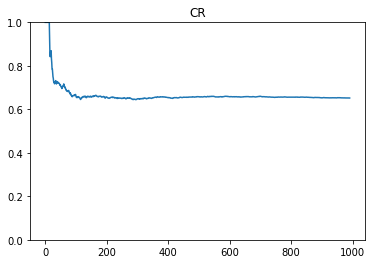

In [1]:
from dispatch.dispatch import Dispatch
from simulator.base_simulator import BaseSimulator
from simulator.graphics import plot_CR

dsp = Dispatch()
sim = BaseSimulator(dsp)

all_metrics = []
for i in range(1000):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()

plot_CR(all_metrics)

NN dispatch

100%|██████████| 1000/1000 [00:55<00:00, 17.93it/s]


micro average CR:  0.49022442522381277
macro average CR:  0.4548339711301314


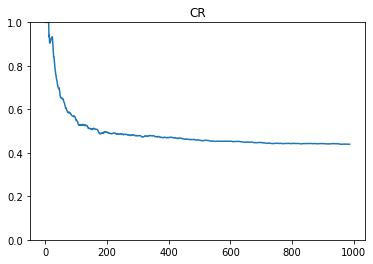

In [3]:
from dispatch.dispatch import NeuralDispatch
from simulator.base_simulator import BaseSimulator
from tqdm import tqdm

dsp = NeuralDispatch(net)
sim = BaseSimulator(dsp)

all_metrics = []
for i in tqdm(range(1000)):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()

plot_CR(all_metrics)

In such base simulations NN dispatch has 15% CR lower